In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle

2025-09-30 08:24:36.178079: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 08:24:36.805088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%reload_ext autoreload
%autoreload 2

from spin_system import SpinSystem
from spin_system import interactions, plots

In [3]:
# magnetization_np = ising_results['magnetization_evolution'].numpy()
# # magnetization_np = abs(magnetization_np)

# steps = magnetization_np.shape[0]
# replicas = magnetization_np.shape[1]

# plt.figure(figsize=(10, 6))

# for r in range(replicas):
#     plt.plot(range(steps), magnetization_np[:, r], alpha=0.5, lw=1)

# mean_magnetization = magnetization_np.mean(axis=1)
# plt.plot(range(steps), mean_magnetization, color="black", lw=2.5, label="Mean")

# plt.xlabel("Monte Carlo steps")
# plt.ylabel("Magnetization")
# plt.title("Evolution of Magnetization per Replica and Mean")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()


In [4]:
# retry = 1
# while retry < 3:
#     try:
#         lattice_dim = 2
#         sweep_length = int(np.round(300000/retry))
#         lattice_length = 32
#         lattice_replicas = 32
#         betas = tf.sort(tf.concat([tf.linspace(0.01, 0.28, 5), tf.linspace(0.29, 0.39, 10), tf.linspace(0.4, 0.45, 15), tf.linspace(0.46, 0.51, 10), tf.linspace(0.52, 0.8, 5)], axis = 0))

#         interaction_matrix = interactions.periodic_nn(lattice_dim, lattice_length)
#         spin_system = SpinSystem(
#             lattice_dim=lattice_dim,
#             lattice_length=lattice_length,
#             lattice_replicas=lattice_replicas,
#             interaction_matrix=interaction_matrix,
#             model="ising",
#             initial_magnetization=0.5,
#         )

#         # Run the multi-temperature sweep
#         results = spin_system.multi_temperature_sweep(
#                 betas=betas,
#                 num_disturb=tf.constant(1, dtype=tf.int32),
#                 sweep_length=sweep_length,
#                 track_spins=False,
#                 track_energy=False,
#                 track_magnetization=True
#         )

#         # Convert tensors to numpy arrays for saving
#         results_to_save = {k: v.numpy() if isinstance(v, tf.Tensor) else v for k, v in results.items()}

#         # Save the dict
#         with open(f'../data/results_{sweep_length}_steps.pkl', 'wb') as f:
#             pickle.dump(results_to_save, f)

#         break

#     except Exception as e:
#         print(f"Error: {e}")
#         retry += 1

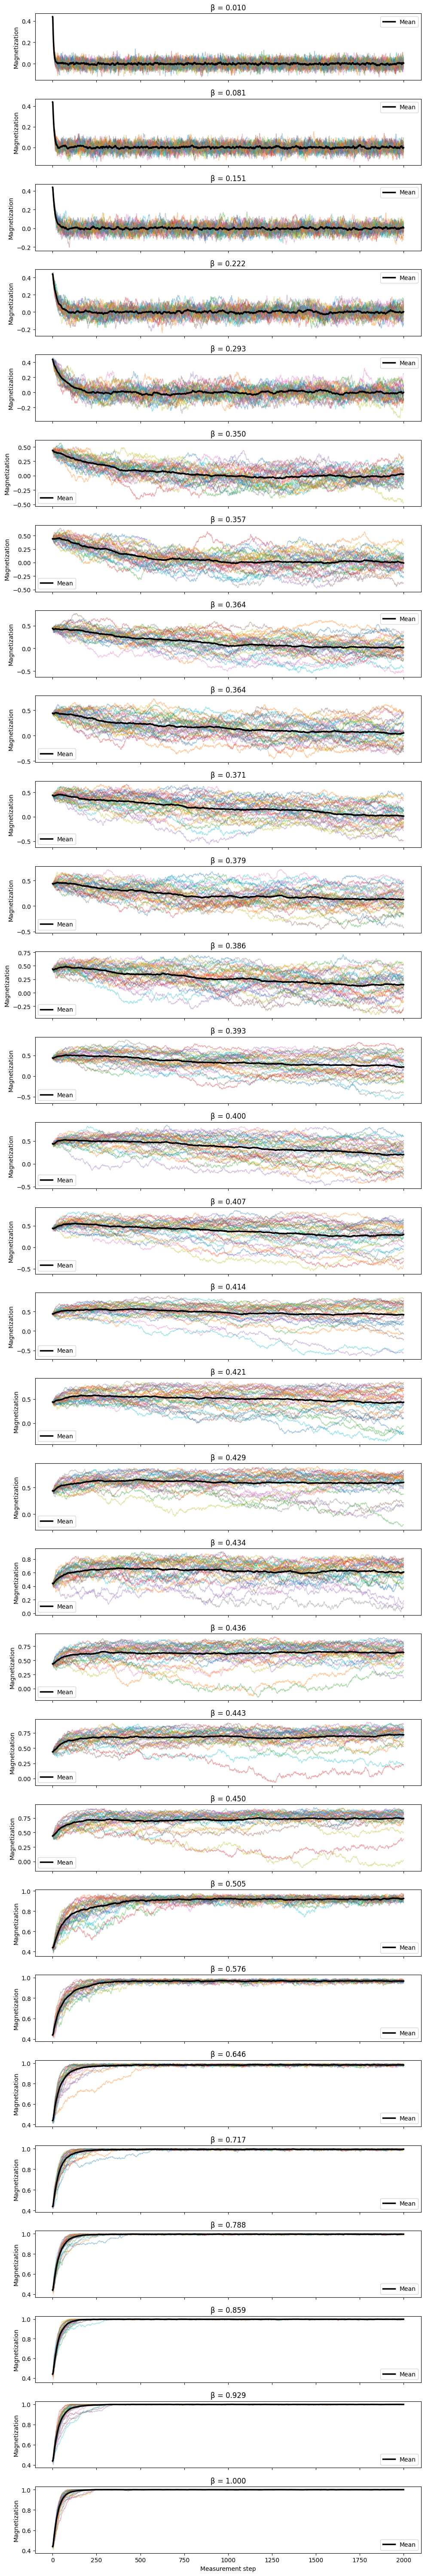

In [15]:
with open('../data/results_2x10e5_steps.pkl', 'rb') as f:
    results = pickle.load(f)

lattice_dim = 2
lattice_length = 32
lattice_replicas = 32
betas = tf.sort(tf.concat([tf.linspace(0.01, 1, 15), tf.linspace(0.35, 0.45, 15)], axis = 0))

# print(results)
# Extract magnetization evolution
# Shape: (n_betas, steps, replicas)
magnetization_np = results["magnetization_evolution"]

n_betas = magnetization_np.shape[0]
steps   = magnetization_np.shape[1]
replicas = magnetization_np.shape[2]

# Plot evolution for each beta
fig, axes = plt.subplots(nrows=n_betas, ncols=1, figsize=(10, 2*n_betas), sharex=True)

if n_betas == 1:
    axes = [axes]  # ensure iterable if only 1 beta

for b in range(n_betas):
    ax = axes[b]

    # magnetization for beta b → shape (steps, replicas)
    magnetization_beta = magnetization_np[b, :, :]

    # plot all replicas
    for r in range(replicas):
        ax.plot(range(steps), magnetization_beta[:, r], alpha=0.4, lw=1)

    # plot mean across replicas
    mean_magnetization = magnetization_beta.mean(axis=1)
    ax.plot(range(steps), mean_magnetization, color="black", lw=2.5, label="Mean")

    ax.set_title(f"β = {betas[b].numpy():.3f}")
    ax.set_ylabel("Magnetization")
    ax.legend()

axes[-1].set_xlabel("Measurement step")
plt.tight_layout()
plt.show()


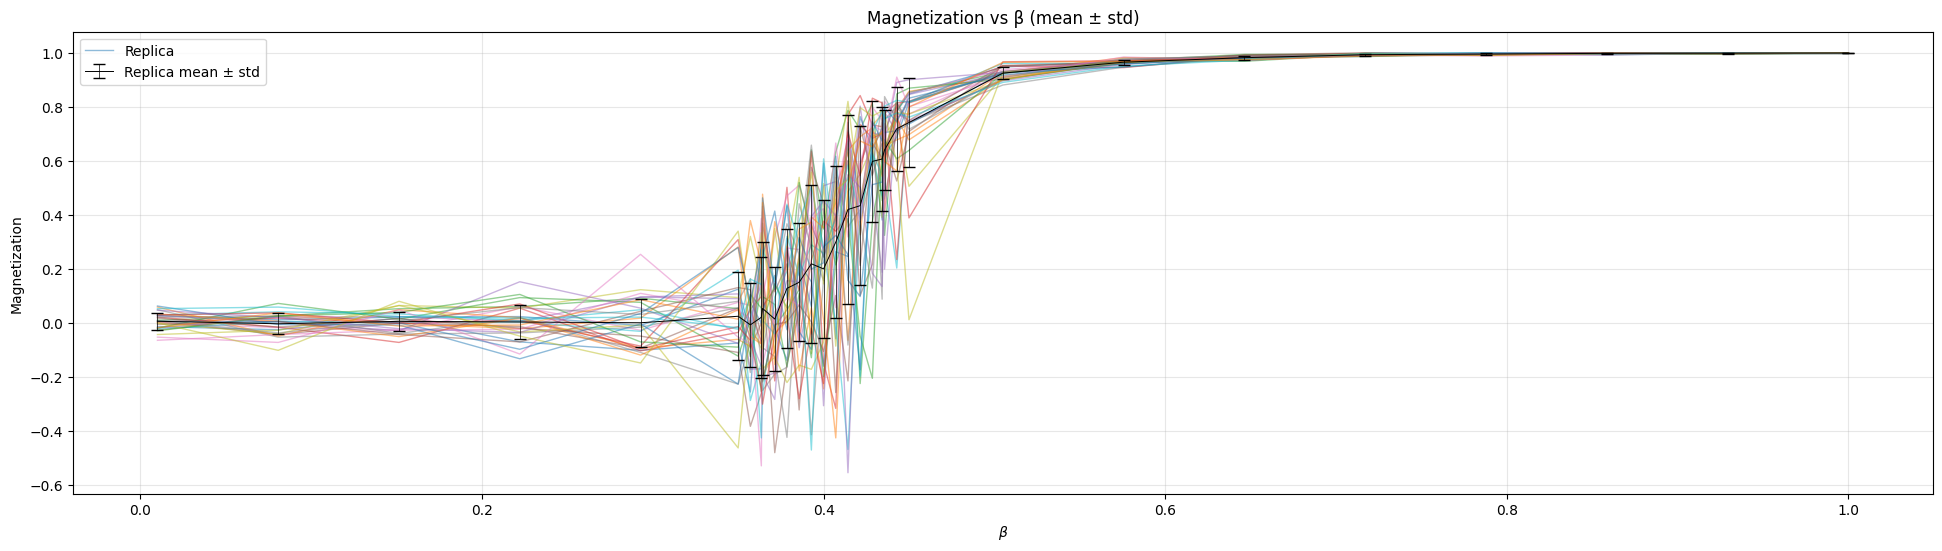

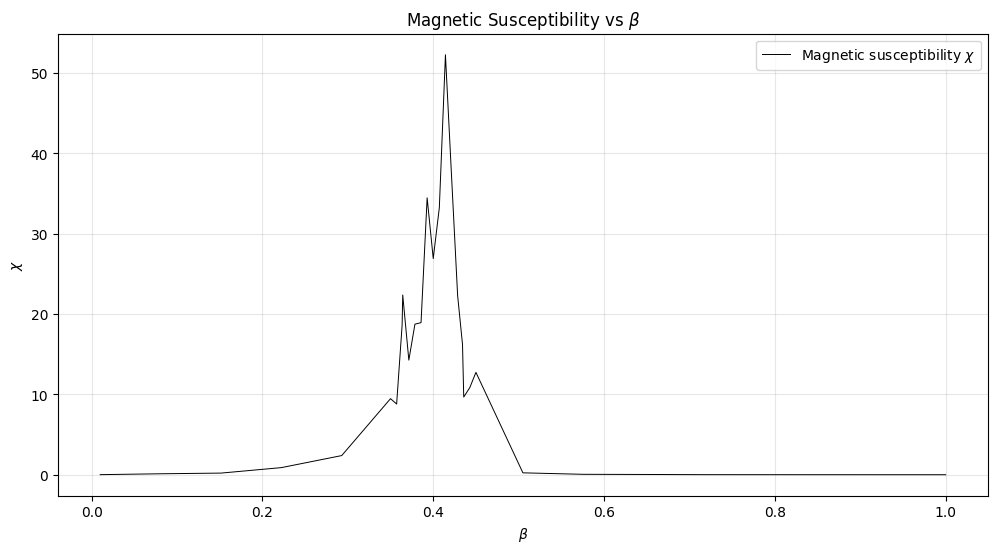

In [16]:
# Take last step for each beta and each replica
final_magnetization_replicas = magnetization_np[:, -1, :]  # shape (n_betas, replicas)

# Compute mean and std across replicas
final_magnetization_mean = final_magnetization_replicas.mean(axis=1)
final_magnetization_std  = final_magnetization_replicas.std(axis=1)

plt.figure(figsize=(24, 6))

# Plot each replica (faded for readability)
for r in range(final_magnetization_replicas.shape[1]):
    plt.plot(
        betas.numpy(),
        final_magnetization_replicas[:, r],
        lw=1,
        alpha=0.5,
        label="Replica" if r == 0 else None,  # only label first one
    )

# Overlay average across replicas in black with error bars
plt.errorbar(
    betas.numpy(),
    final_magnetization_mean,
    yerr=final_magnetization_std,
    # fmt="o-",
    color="black",
    # ecolor="gray",
    elinewidth=0.5,
    capsize=4,
    lw=0.7,
    label="Replica mean ± std"
)

plt.xlabel(r"$\beta$")
plt.ylabel("Magnetization")
plt.title("Magnetization vs β (mean ± std)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

N = lattice_length ** lattice_dim  # total number of spins
final_magnetization_replicas = magnetization_np[:, -1, :]  # shape (n_betas, replicas)

# Variance across replicas
final_magnetization_var = final_magnetization_replicas.var(axis=1)

# Susceptibility (assuming magnetization is total, not normalized — if normalized, drop N factor)
susceptibility = betas.numpy() * N * final_magnetization_var

plt.figure(figsize=(12, 6))
plt.plot(
    betas.numpy(),
    susceptibility,
    lw=.7,
    color="black",
    label=r"Magnetic susceptibility $\chi$",
)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\chi$")
plt.title(r"Magnetic Susceptibility vs $\beta$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [17]:
# spherical_spin_system = SpinSystem(
#     lattice_dim=lattice_dim,
#     lattice_length=lattice_length,
#     lattice_replicas=lattice_replicas,
#     interaction_matrix=interactions.decaying(lattice_dim, lattice_length, 10, 2),
#     model="spherical",
#     spherical_constraint=True
# )

# spherical_results = spherical_spin_system.metropolis_sweep(1, theta_max = 2*np.pi, sweep_length = 100000)

In [18]:
# magnetization_np = spherical_results['magnetization_evolution'].numpy()

# steps = magnetization_np.shape[0]
# replicas = magnetization_np.shape[1]

# plt.figure(figsize=(10, 6))

# for r in range(replicas):
#     plt.plot(range(steps), magnetization_np[:, r], alpha=0.5, lw=1)

# mean_magnetization = magnetization_np.mean(axis=1)
# plt.plot(range(steps), mean_magnetization, color="black", lw=2.5, label="Mean")

# plt.xlabel("Monte Carlo steps")
# plt.ylabel("Magnetization")
# plt.title("Evolution of Magnetization per Replica and Mean")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()


In [19]:
# energy_np = spherical_results['energy_evolution'].numpy()

# steps = energy_np.shape[0]
# replicas = energy_np.shape[1]

# plt.figure(figsize=(10, 6))

# for r in range(replicas):
#     plt.plot(range(steps), energy_np[:, r], alpha=0.5, lw=1)

# mean_energy = energy_np.mean(axis=1)
# plt.plot(range(steps), mean_energy, color="black", lw=2.5, label="Mean")

# plt.xlabel("Monte Carlo steps")
# plt.ylabel("Energy")
# plt.title("Evolution of Energy per Replica and Mean")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()